#  Glass Classification Report

### ***note: all tables and figure should have a figure/table number and a legend

## Introduction

   Glass is a ubiquitous material that can be found at most crime scenes. The classification of glass fragments is an essential aspect of forensic investigation, particularly in cases that involve broken windows, bottles and/or any other glass objects that can be found present. It can provide crucial evidence that may help investigators identify suspects or even vindicate the innocent. Glass fragments can be found on clothing and vehicles in addition to being recovered from wounds and weapons. These fragments can provide valuable clues about the source, direction and nature of the impact that led to them to break, which can be useful to investigators when reconstructing the sequence of events leading up to the crime. However, not all glass is created equal, and the classification of glass is essential to determining its origin and potential significance as well as for ruling out false matches.

   An article written by Grzegorz Zadora titled Glass analysis for forensic purposes- a comparison of classification methods states that many forensic experts analyze glass fragments under 0.5mm, therefore they must be able to accurately collect the physico-chemical features of the glass, such as Refractive Index (RI) in addition to elemental analysis. By using Scanning Electron Microscopy that has been coupled with an Energy Dispersive X-ray spectrometer (SEM-EDX), the investigators are provided with the information of major and minor elements such as Al, Mg, K, Ca and Fe. Furthermore, it is believed that obtaining the information about such elements are extremely important when comparing and individualizing the glass fragments (Zadora, G. 2007).

    #talk here about what we obtain for data results.

   The dataset used was sourced from the UCI Machine Learning Repository. The chosen dataset, Glass Identification comes from the USA Forensic Science Service and classifies 6 types of glass based on their oxide content, along with the refractive index of each glass observation. Also note that float-processing is a glass manufacturing process that creates a smooth, thick and uniform surface. In this dataset, there is no data for “vehicle_windows_non_float_processed” glass.

<b>More details on the glass identification dataset:</b>

<b>Glass Oxides (measured in weight percent)</b>
<ul>
<li>Na: Sodium</li>
<li>Mg: Magnesium</li>
<li>Al: Aluminum</li>
<li>Si: Silicon</li>
<li>K: Potassium</li>
<li>Ca: Calcium</li>
<li>Ba: Barium</li>
<li>Fe: Iron</li>
</ul>
<b>Glass Types</b>
<ul>
<li>building_windows_float_processed</li>
<li>building_windows_non_float_processed</li>
<li>vehicle_windows_float_processed</li>
<li>vehicle_windows_non_float_processed (**none in this dataset**)</li>
<li>containers</li>
<li>tableware</li>
<li>headlamps</li>
</ul>

## Methods & Results

In [9]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("themis")
library(themis)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



#### Load Data From the Original Source

Here we load the data from the original source with new column names and visualized a few rows of raw data `glass_data_raw`.

In [10]:
set.seed(999)

dataset_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
col_names <- c("id", "RI", "Na", "Mg", "Al", "Si", "K", "Ca", "Ba", "Fe", "glass_type")
glass_data_raw <- read.table(dataset_url, sep =",", header = FALSE, col.names = col_names)

sample_n(glass_data_raw, 5)

id,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,glass_type
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
155,1.51694,12.86,3.58,1.31,72.61,0.61,8.79,0,0.00,3
68,1.52152,13.05,3.65,0.87,72.32,0.19,9.85,0,0.17,1
61,1.51905,13.60,3.62,1.11,72.64,0.14,8.76,0,0.00,1
71,1.51574,14.86,3.67,1.74,71.87,0.16,7.36,0,0.12,2
105,1.52410,13.83,2.90,1.17,71.15,0.08,10.79,0,0.00,2


#### Wrangle and Clean the Data

Here we change the glass_type column to a factor type, remove the refractive index column (RI) and ID (id), and replace the glass_type numbers with their corresponding labels. We also visualize a few rows of `glass_data_processed`.

In [11]:
set.seed(999)

glass_data_raw <- glass_data_raw |> mutate(glass_type = as_factor(glass_type))
glass_type_names <- c("building_windows_float_processed", "building_windows_non_float_processed", "vehicle_windows_float_processed", "containers", "tableware", "headlamps")
glass_data_processed <- glass_data_raw |> select(-RI, -id)
levels(glass_data_processed$glass_type) <- glass_type_names

sample_n(glass_data_processed, 5)

Na,Mg,Al,Si,K,Ca,Ba,Fe,glass_type
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
12.86,3.58,1.31,72.61,0.61,8.79,0,0.00,vehicle_windows_float_processed
13.05,3.65,0.87,72.32,0.19,9.85,0,0.17,building_windows_float_processed
13.60,3.62,1.11,72.64,0.14,8.76,0,0.00,building_windows_float_processed
14.86,3.67,1.74,71.87,0.16,7.36,0,0.12,building_windows_non_float_processed
13.83,2.90,1.17,71.15,0.08,10.79,0,0.00,building_windows_non_float_processed


#### Data Set Summary and Exploratory Data Analysis

**Glass Type Counts**<br>

Visualizing the glass type counts of the data set we can see that the observations of each glass type are not balanced. For examample there is a proporitionally high number of building_windows_float_processed observations and low tableware observations. This may lead to a bias towards our model predicting the higher count classes so to try and mitigate this we will use step_upsample from the themis package to balance the observations.

In [12]:
glass_type_counts <- glass_data_processed |>
    group_by(glass_type) |>
    summarize(count = n())

glass_type_counts

glass_type,count
<fct>,<int>
building_windows_float_processed,70
building_windows_non_float_processed,76
vehicle_windows_float_processed,17
containers,13
tableware,9
headlamps,29


**Average Weight Percent of Oxide per Glass Type**<br>

Here we visualize the average weight percentage of oxides for every glass type. This allows us to compare the average weight percent of each oxide between glass types.

Based on the visualization we can see **//TODO: write some stuff about how oxide types differ and maybe choose ones that differ to use in our predictors**

`summarise()` has grouped output by 'glass_type'. You can override using the
`.groups` argument.


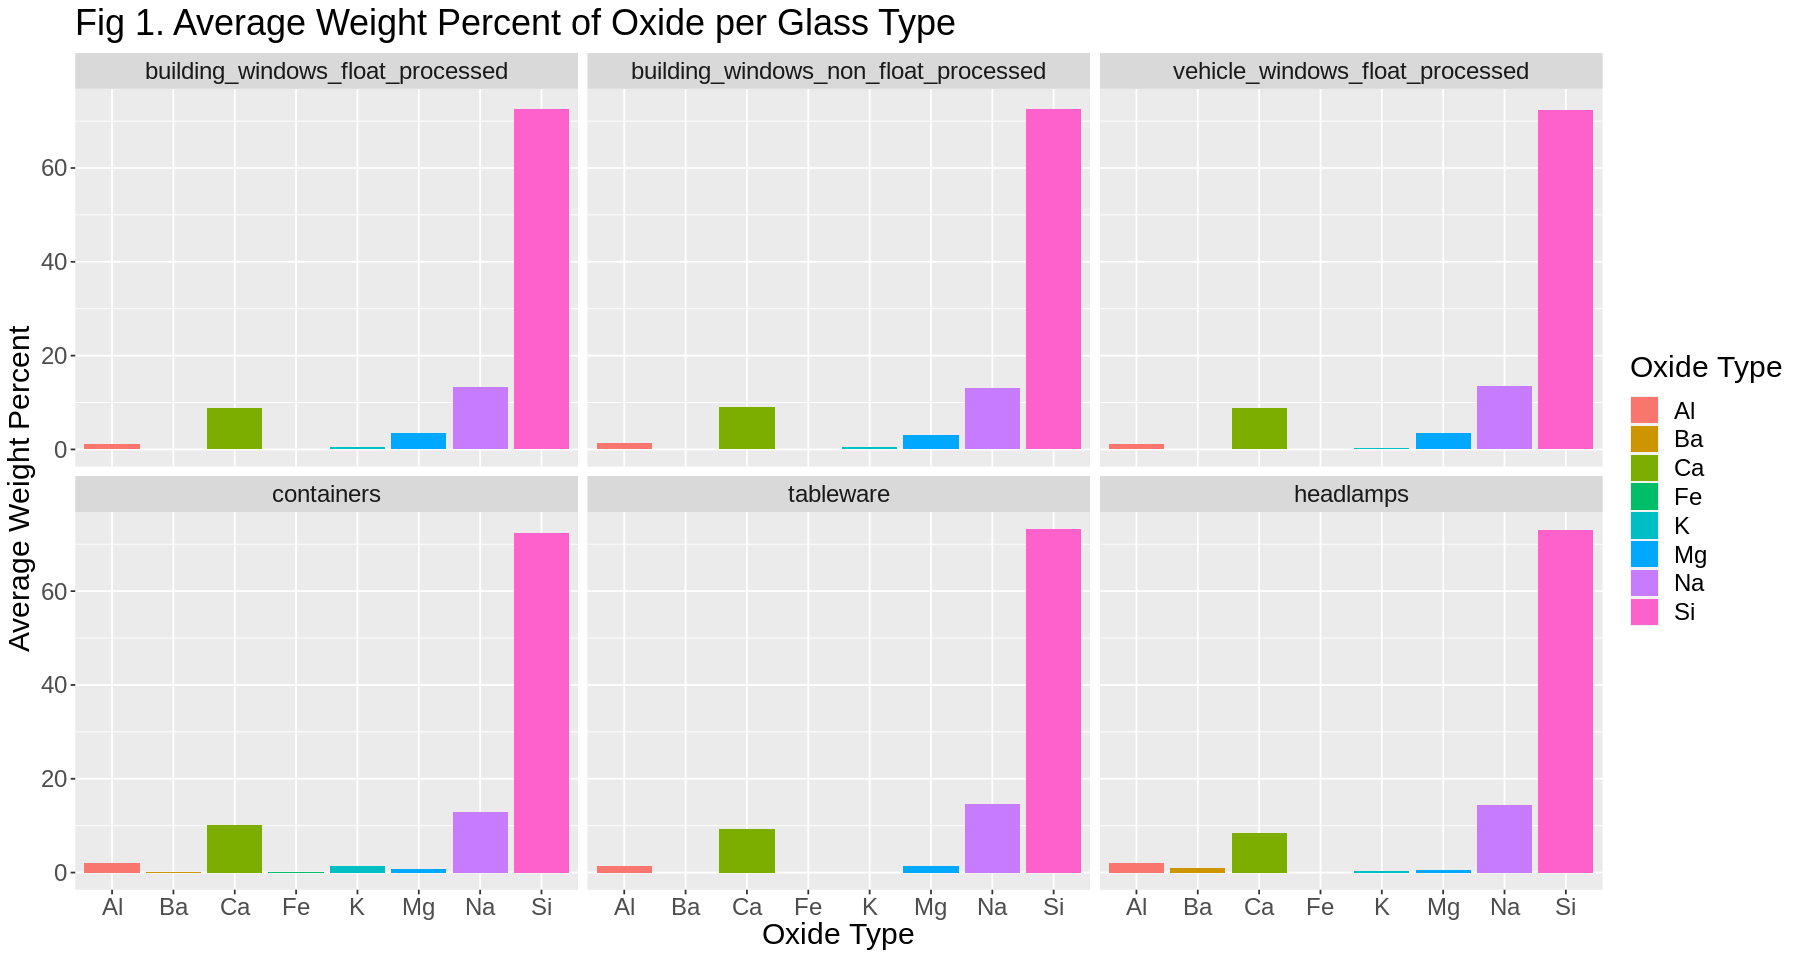

In [13]:
options(repr.plot.width=15, repr.plot.height=8)

glass_visual_data <- glass_data_processed |>
    pivot_longer(cols = Na:Fe, names_to = "oxide_type", values_to = "weight_percent") |>
    group_by(glass_type, oxide_type) |>
    summarise(mean_weight_percent = mean(weight_percent)) |>
    ungroup()

glass_visual_plot <- glass_visual_data |>
    ggplot(aes(x = oxide_type, y = mean_weight_percent, fill = oxide_type)) +
    geom_bar(stat = "identity", position = "dodge") +
    labs(x = "Oxide Type", y = "Average Weight Percent", fill = "Oxide Type") +
    facet_wrap(~glass_type, nrow = 2) +
    theme(text = element_text(size = 18)) +
    ggtitle("Fig 1. Average Weight Percent of Oxide per Glass Type")

glass_visual_plot

**TODO: Any other exploratory analysis we can do?**

To decide on what predictors we should use, we can analyze the range of values of all oxides in the original dataset.  We can assume that oxides with larger ranges of values can be better predictors of glass type. The range can be calculated by subtracting the maximum and minimum values that appear in the dataset......

In [57]:
sample <- glass_data_raw |>
            select(-c(RI, id, glass_type))


glass_min <- apply(sample, 2, min)
glass_max <- apply(sample, 2, max)
glass_range <- round(glass_max - glass_min, 1)
glass_mean <- round(apply(sample, 2, mean), 1)

cat("Range of values")
glass_range
cat("Mean value")
glass_mean

Range of values

Na   Mg   Al   Si    K   Ca   Ba   Fe 
 6.6  4.5  3.2  5.6  6.2 10.8  3.1  0.5

Mean value

Na   Mg   Al   Si    K   Ca   Ba   Fe 
13.4  2.7  1.4 72.7  0.5  9.0  0.2  0.1

#### Performing the Data Analysis

**Splitting the Data**<br>

Here we split the original data set into a training and testing set called `glass_train` and `glass_test`, respectively.

In [34]:
set.seed(9999)

# reanme final processed data set to improve readability
glass_data <- glass_data_processed

# remove Aluminum, Barium, and Iron from data for data analysis
glass_data <- glass_data |> select(-Al, -Ba, -Fe)

# split dataset into training and testing data
glass_split <- initial_split(glass_data, prop = 0.8, strata=glass_type)
glass_train <- training(glass_split)
glass_test <- testing(glass_split)

**Choosing the Optimal Number of Neighbors $k$** <br>

Here we use 5-fold cross-validation on the training data set to select which 𝑘 (neighbors) is the most optimal for our data set for k-nn classification.

**TODO: List steps performed (comments)**

In [35]:
set.seed(999)

# Create model specification with tuning on the number of neighbours
glass_spec <- nearest_neighbor(weight_func="rectangular", neighbors = tune()) |>
    set_engine("kknn") |>
    set_mode("classification")

# Create a recipe that uses all predictors
glass_recipe <- recipe(glass_type ~ ., data = glass_train) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(glass_type)

# Perform 5-fold cross validation
vfold <- vfold_cv(glass_train, v=5, strata=glass_type)

vals <- tibble(neighbors = seq(from=1, to = 20))

# Create a workflow analysis trying k in vals
knn_results <- workflow() |>
    add_recipe(glass_recipe) |>
    add_model(glass_spec) |>
    tune_grid(resamples = vfold, grid = vals)

# Collect the metrics from the workflow analysis 
knn_results <- knn_results |> collect_metrics()

accuracies <- knn_results |>
    filter(.metric =="accuracy")

! Fold1: internal:
  No observations were detected in `truth` for level(s): 'tableware'
  Computation will proceed by ignoring those levels.

! Fold4: internal:
  No observations were detected in `truth` for level(s): 'tableware'
  Computation will proceed by ignoring those levels.



We then plot the $k$ (neighbors) vs the accuracy. 
**TODO: write some analylsis comments about the graph**

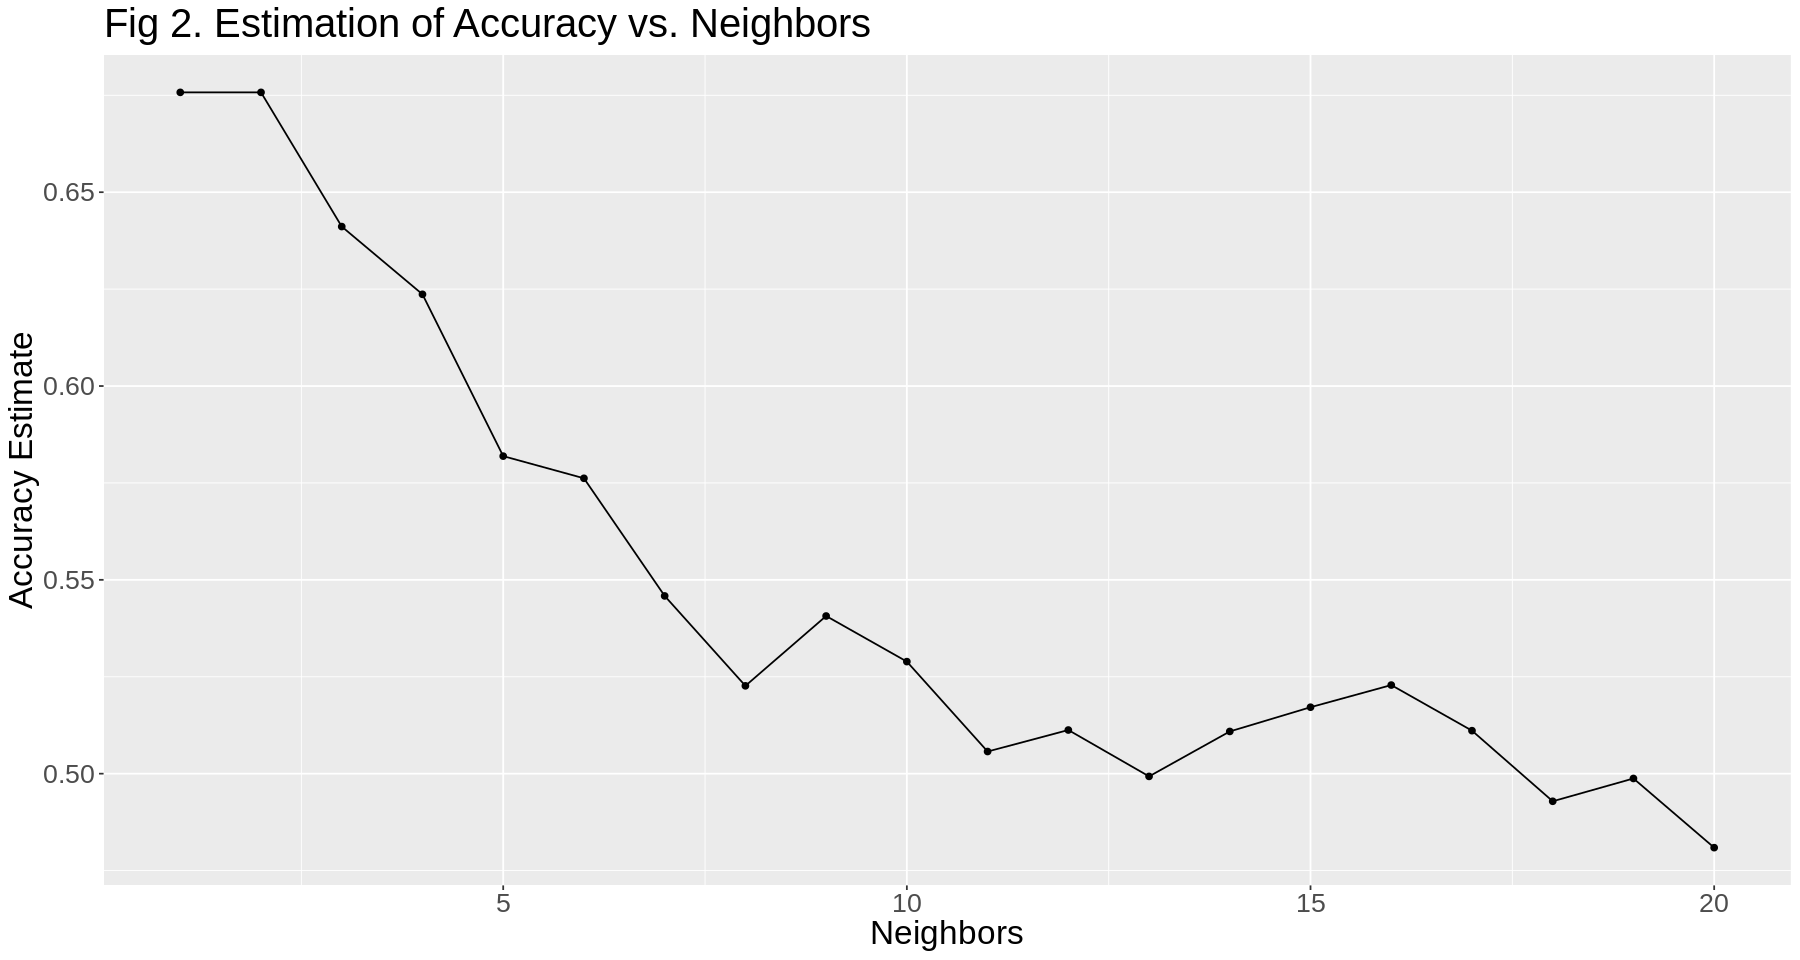

In [36]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
  geom_point() +
  geom_line() +
  labs(x = "Neighbors", y = "Accuracy Estimate") + 
  theme(text = element_text(size = 20)) +
  ggtitle("Fig 2. Estimation of Accuracy vs. Neighbors")
accuracy_vs_k

**Build the Model**

In [ ]:
set.seed(999)

# Get the number of neighbors that gave the highest accuracy
best_neighbors <- accuracies$neighbors[which.max(accuracies$mean)]

# Build model specification with the best value for k
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = best_neighbors) |> 
            set_engine("kknn") |> 
            set_mode("classification") 

knn_fit <- workflow() |> 
            add_recipe(glass_recipe) |> 
            add_model(knn_spec) |> 
            fit(data = glass_train) 

**Predicting on the Test Data**<br>

We use our final model to predict on the test dataset and assign this to an object called `glass_test_predictions`. We report the accuracy of this prediction, and store this in an object named `glass_test_metrics`. We also report the confusion matrix and and store this in an object named `glass_test_conf_mat`. 

In [ ]:
set.seed(999)

glass_test_predictions <- predict(knn_fit, glass_test) |> 
                            bind_cols(glass_test)

glass_test_metrics <- glass_test_predictions |>
    metrics(truth = glass_type, estimate = .pred_class)

glass_test_conf_mat <- glass_test_predictions |> 
    conf_mat(truth = glass_type, estimate = .pred_class)


head(glass_test_predictions)
glass_test_metrics
glass_test_conf_mat

#Using algorithm on test data with k = 1 and creating a confusion matrix
#Not sure how useful this section so feel free to take it out if it doesn't seem to helpful
#I was thinking it might be helpful for the written portion of our report to show where the inaccuracies in our model are primarily coming from
#We can directly see that glass types with fewer observations have more unpredictable 
#accuracies, but generally have lower accuracies
#The concern with having certain glass types overrepresented in dataset is that they would skew results of predictions towards them. Even though 
#building_windows_float_processed and building_windows_non_float_processed are the most represented, not all of the largest errors come in these categories. 

**Determine an Accuracy Baseline**

Here we determine an accuracy baseline based on a model that always chooses the most common class.

In [ ]:
# COMMENT IF THE FOLLOWING DOESN'T MAKES SENSE

# Get the accuracy of the KNN model with the best number of neighbors
knn_accuracy <- accuracies$mean[which.max(accuracies$mean)]

# Implementing the Most Common Class model
# Create a table of class counts in the training data
class_counts <- table(glass_train$glass_type)
# Get the class with the highest count
most_common_class <- names(which.max(class_counts))
# Create a vector of predictions for the test data using the most common class
most_common_predictions <- rep(most_common_class, nrow(glass_test))
# Calculate the accuracy of the baseline model
most_common_accuracy <- mean(most_common_predictions == glass_test$glass_type)

accuracy_tbl <- tibble(Model = c("KNN", "Most Common"),
                       Accuracy = c(knn_accuracy, most_common_accuracy)) #!!!
accuracy_tbl